In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stan
from sklearn.model_selection import train_test_split
import nest_asyncio
nest_asyncio.apply()

## Join All Hourly Data

In [6]:
# setting the path for joining multiple files
files = os.path.join("../data/epa/TXHOURLY", "*tx*.csv")

# list of merged files returned
files = glob.glob(files)

print("Resultant CSV after joining all CSV files at a particular location...");

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
cols = ['ORISPL_CODE', 'UNITID', 'OP_HOUR', 'GLOAD (MW)', 'SO2_RATE (lbs/mmBtu)',
       'NOX_RATE (lbs/mmBtu)', 'CO2_RATE (tons/mmBtu)', 'HEAT_INPUT (mmBtu)']
df = df[cols]
df.dropna(inplace=True)


Resultant CSV after joining all CSV files at a particular location...


## Stan Code

In [4]:
co2_model = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
model {
  alpha ~ normal(0, 10);      // prior for intercept
  beta ~ normal(0, 10);       // prior for coefficients
  sigma ~ cauchy(0, 5);       // prior for error scale
  y ~ normal(x * beta + alpha, sigma);  // likelihood
}
"""

In [9]:
d = df.loc[df.OP_HOUR ==1]
d = pd.get_dummies(d, columns=['ORISPL_CODE', 'UNITID'])
X = d.drop('CO2_RATE (tons/mmBtu)', axis=1).to_numpy()
y = d['CO2_RATE (tons/mmBtu)'].to_numpy()

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [10]:
N = X_train.shape[0]
K = X_train.shape[1]

In [11]:
epa_data = {"N": N,
                "K": K,
                "x": X_train,
                "y": y_train}

In [12]:
posterior = stan.build(co2_model, data=epa_data)
fit = posterior.sample(num_chains=1, num_samples=100)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/1100)

In [136]:
vars = fit.to_frame().mean()

In [137]:
vars

parameters
lp__            -124801.106252
accept_stat__         0.950406
stepsize__            0.022640
treedepth__           6.510000
n_leapfrog__        121.080000
divergent__           0.000000
energy__         124805.101711
alpha               -43.981856
beta.1               -0.046093
beta.2                0.014172
beta.3               26.617624
beta.4               45.090966
beta.5                0.100914
beta.6                0.096189
sigma                27.815977
dtype: float64

In [138]:
alpha = vars["alpha"]
B = vars[8:14]
sigma = vars["sigma"]

def predict(alpha, B, X, sigma):
    return alpha + np.dot(X, B) + np.random.normal(0, sigma)


In [139]:
pred = predict(alpha, B, X_test, sigma)


In [148]:
#calculate mean squared error
mse = np.mean((pred - y_test)**2)

In [149]:
mse

764.6305609390657

Text(0.5, 1.0, 'Histogram of Residuals')

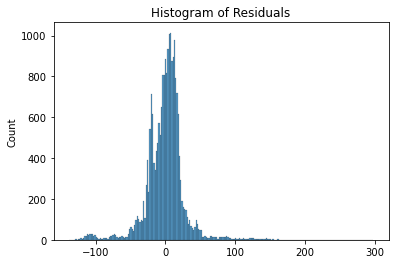

In [152]:
sns.histplot(pred-y_test)
plt.title("Histogram of Residuals")

Text(0.5, 1.0, 'CO2_RATE (tons/mmBtu) Distribution')

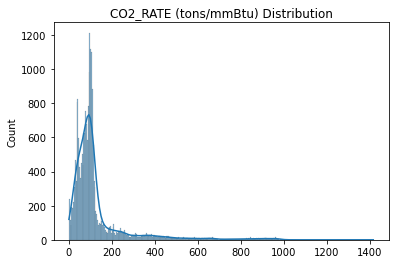

In [151]:
sns.histplot(y_test, kde=True)
plt.title("CO2_RATE (tons/mmBtu) Distribution")

/opt/anaconda3/envs/science/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Predicted vs Actual')

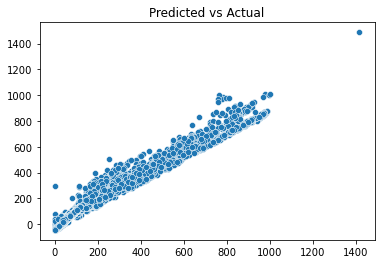

In [154]:
sns.scatterplot(y_test, pred)
plt.title("Predicted vs Actual")